In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from collections import Counter  
from imblearn.over_sampling import RandomOverSampler
import incertidumbre


from sklearn.metrics import confusion_matrix

In [11]:
#Extraccion y limpieza de datos.

datos_diabetes = pd.read_csv('/home/juan/machineLearning2025/datasets/diabetes_012_health_indicators_BRFSS2015.csv')

datos_diabetes['diabetes_01'] = datos_diabetes['Diabetes_012']
datos_diabetes['diabetes_01'] = datos_diabetes['diabetes_01'].replace(2,1)

#Reparar nombres de columnas. Se usa el formato loweCamelCase para el nombre de las caracteristicas.

new_col_names = []

for name in datos_diabetes.columns:
    # Luego, pon todas las letras en minúsculas
    name_lowered_first_letter = name[0].lower() + name[1:]
    # Elimina los espacios al principio y al final
    name_stripped = name_lowered_first_letter.strip()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_stripped.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_names.append(name_no_spaces)

datos_diabetes.columns = new_col_names

datos_diabetes = datos_diabetes.rename(columns={'bMI':'bmi'})

#Definicion de datos enteros.
for col in datos_diabetes.columns:
    #if datos_diabetes[col].dtype == 'float64':
    datos_diabetes[col] = datos_diabetes[col].astype(int)


In [12]:
X = datos_diabetes.drop(["diabetes_01", "diabetes_012"], axis=1)
y = datos_diabetes["diabetes_01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


In [13]:
#Balanceamos con RandomOverSampler
os =  RandomOverSampler()
X_train_balanced, y_train_balanced = os.fit_resample(X_train, y_train)

print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_balanced)))

before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 160225, 1: 160225})


In [16]:
#Funciones run_model() y evaluate_model()
def run_model(X_train, X_test, Y_train, Y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, Y_train)
    return clf_base
def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return eval_stats['train']['F1'], eval_stats['test']['F1']

In [17]:
regresion_log = run_model(X_train_balanced, X_test, y_train_balanced, y_test)

           train  test
Exactitud   0.74  0.73
F1          0.75  0.47
APS         0.79  0.43
ROC AUC     0.82  0.82


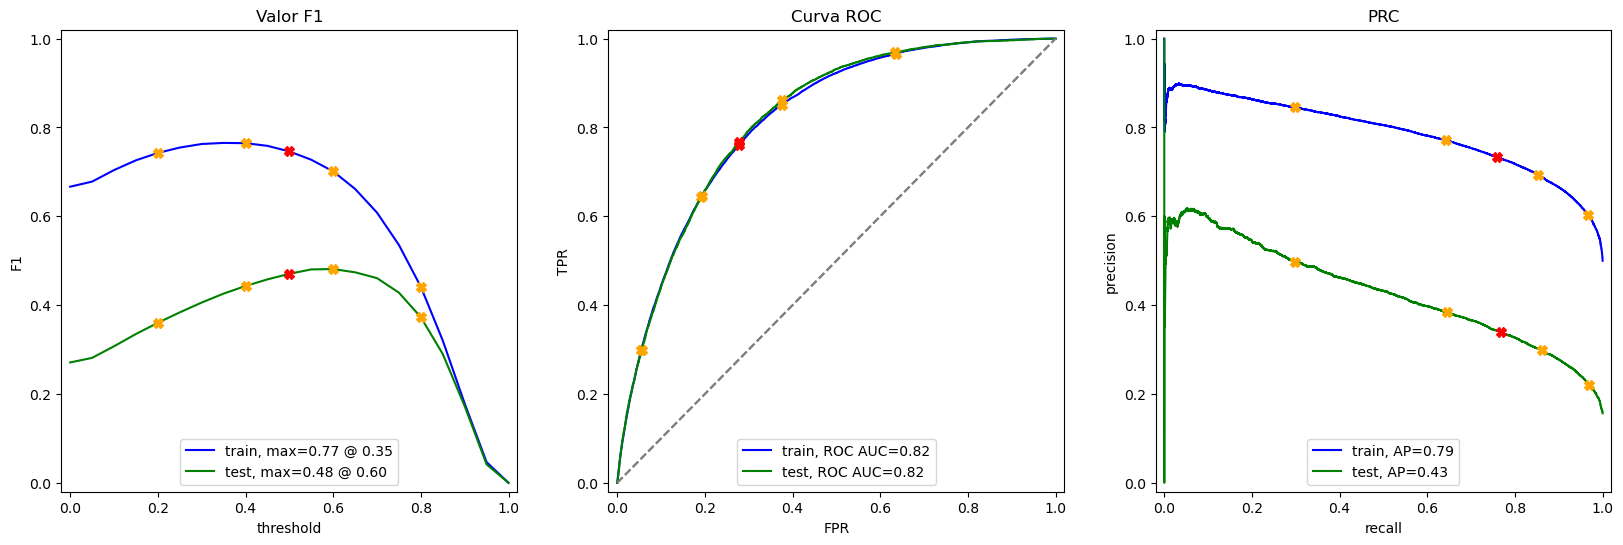

In [18]:
train_f1, test_f1 = evaluate_model(regresion_log, X_train_balanced, y_train_balanced, X_test, y_test)

In [19]:
y_predict = regresion_log.predict(X_test)

In [21]:
cf =confusion_matrix(y_test, y_predict)
tn, fp, fn, tp = cf.ravel()
v_LR = np.array([tp, tn, fp, fn])
v_LR

array([ 7639, 38590, 14888,  2303])

In [33]:
distribucion_f1_bootstrap = incertidumbre.boot_sampler(
    performance_indicator=incertidumbre.f1_score, 
    v=v_LR, 
    B=100000
)


In [34]:
print("\n--- Resultados para el Clasificador con Bootstrap ---")
print(f"Media de la distribución posterior de MCC: {np.mean(distribucion_f1_bootstrap):.4f}")
print(f"Desviación estándar de la distribución: {np.std(distribucion_f1_bootstrap):.4f}")
cred_interval_bootstrap = np.percentile(distribucion_f1_bootstrap, [2.5, 97.5])
print(f"Intervalo de credibilidad del 95% para MCC: [{cred_interval_bootstrap[0]:.4f}, {cred_interval_bootstrap[1]:.4f}]")


--- Resultados para el Clasificador con Bootstrap ---
Media de la distribución posterior de MCC: 0.4705
Desviación estándar de la distribución: 0.0034
Intervalo de credibilidad del 95% para MCC: [0.4638, 0.4773]


In [35]:
alpha_0 = np.array([0, 0, 0, 0]) 

distribucion_f1_bayes = incertidumbre.mc_bayes_sampler(
    performance_indicator=incertidumbre.f1_score,
    alpha=alpha_0,
    v=v_LR,
    M=100000
)

In [36]:
print("\n--- Resultados para el Clasificador con Bayes ---")
print(f"Media de la distribución posterior de MCC: {np.mean(distribucion_f1_bayes):.4f}")
print(f"Desviación estándar de la distribución: {np.std(distribucion_f1_bayes):.4f}")
# Calcular el intervalo de confianza del 95% con bayes
cred_interval_bayes = np.percentile(distribucion_f1_bayes, [2.5, 97.5])
print(f"Intervalo de credibilidad del 95% para MCC: [{cred_interval_bayes[0]:.4f}, {cred_interval_bayes[1]:.4f}]")



--- Resultados para el Clasificador con Bayes ---
Media de la distribución posterior de MCC: 0.4705
Desviación estándar de la distribución: 0.0049
Intervalo de credibilidad del 95% para MCC: [0.4610, 0.4800]
